In [1]:
# library
import math
import random
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.utils import resample
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
# load cleaned data
data = pd.read_pickle("cleaned.pkl")

In [3]:
data

company_profile  \
0      food52 weve created groundbreaking awardwinnin...   
1      90 seconds worlds cloud video production servi...   
2      valor services provides workforce solutions me...   
3      passion improving quality life geography heart...   
4      spot source solutions llc global human capital...   
...                                                  ...   
17875  vend looking awesome new talent come join us y...   
17876  web linc ecommerce platform services provider ...   
17877  provide full time permanent positions many med...   
17878                                                 na   
17879  Vend is looking for some awesome new talent to...   

                                             description  \
0      food52 fastgrowing james beard awardwinning on...   
1      organised focused vibrant awesomedo passion cu...   
2      client located houston actively seeking experi...   
3      company esri environmental systems research in...   
4      job title itemization review manager location ...   
...                                                  ...   
17875  case first time youve visited website vend awa...   
17876  payroll accountant focus primarily payroll fun...   
17877  experienced project cost control staff enginee...   
17878  nemsia studios looking experienced visualgraph...   
17879  wevend award winning web based point sale soft...   

                                            requirements  \
0      experience content management systems major pl...   
1      expect key responsibility communicate client 9...   
2      implement precommissioning commissioning proce...   
3      education bachelors masters gis business admin...   
4      qualifications rn license state texas diploma ...   
...                                                  ...   
17875  ace role eat comprehensive statements work bre...   
17876  ba bs accounting desire fun love genuine passi...   
17877  least 12 years professional experienceability ...   
17878  1 must fluent latest versions corel amp adobe ...   
17879  We want to hear from you if:You have an in-dep...   

                                                benefits  fraudulent  
0      experience content management systems major pl...           0  
1      expect key responsibility communicate client 9...           0  
2      implement precommissioning commissioning proce...           0  
3      education bachelors masters gis business admin...           0  
4      qualifications rn license state texas diploma ...           0  
...                                                  ...         ...  
17875  ace role eat comprehensive statements work bre...           0  
17876  ba bs accounting desire fun love genuine passi...           0  
17877  least 12 years professional experienceability ...           0  
17878  1 must fluent latest versions corel amp adobe ...           0  
17879                                                 NA           0  

[17879 rows x 5 columns]

In [4]:
# We connect all text together as one feature.
data["full_text"] = data["company_profile"] + " " + data["description"] + " " + data["requirements"] + " " + data["benefits"]

In [5]:
# Check if there has any Null value
null_all = data.isnull().sum()
print(null_all)

company_profile    0
description        0
requirements       0
benefits           0
fraudulent         0
full_text          0
dtype: int64


# Balance Data Set

In [6]:
# Check if imbalance data by using bar figure.
plt.figure(figsize = (10,10))
sns.countplot(x="fraudulent", data=data)
plt.title("Real Vs. Fake postings count", fontsize = 15)
plt.show()

In [7]:
train, test = train_test_split(data, test_size=0.2, random_state = 1)

In [8]:
# Check imbalance data distribution.
print("Number of cases: " , len(train))
print("Number of fraudulent cases: ", len(train[train["fraudulent"] == 1]))
print("Number of non fraudulent cases: ", len(train[train["fraudulent"] == 0]))

Number of cases:  14303
Number of fraudulent cases:  708
Number of non fraudulent cases:  13595


In [9]:
# Random seed.
random.seed(1)

# Since the fraudulent cases is extremely less than non-fradulent cases, we assign non-fraudulent as majority.
df_majority = train[train["fraudulent"]== 0]
df_minority = train[train["fraudulent"]== 1]

# Upsample the dataset by simply copying records from minority classes by using resample().
# The value for the n_samples parameter is set to a half of the number of majority class to avoid overfitting.
negative_upsample = resample(df_minority, replace = True, 
                        n_samples = math.ceil(df_majority.shape[0]/2),
                        random_state = 101)

# Aslo, we need to undersample majority classes
negative_undersample = resample(df_majority, replace = True, 
                        n_samples = math.ceil(df_majority.shape[0]/2),
                        random_state = 101)

# Concat two dataframes (majority class and upsampled minority class).
df_upsampled = pd.concat([negative_undersample, negative_upsample])
df_upsampled = df_upsampled.sample(frac = 1, random_state = 101)

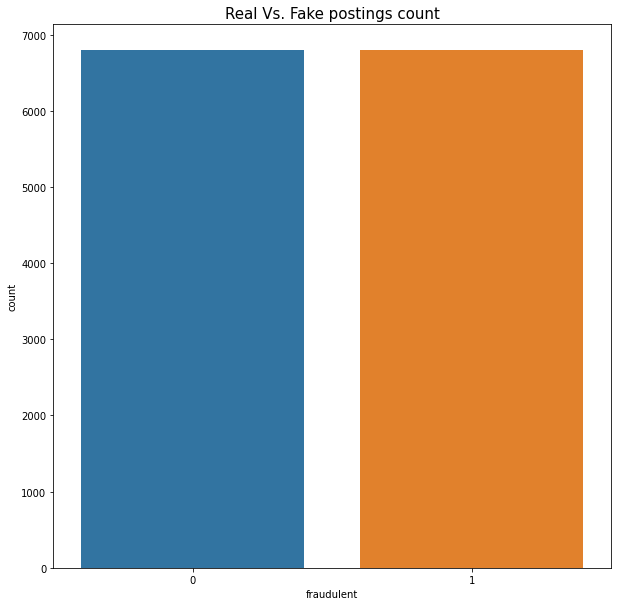

In [10]:
# Show data distribution after resample
plt.figure(figsize = (10,10))
sns.countplot(x="fraudulent", data=df_upsampled)
plt.title("Real Vs. Fake postings count", fontsize = 15)
plt.show()

In [11]:
# Check data after resample.
print("Number of cases: " , len(df_upsampled))
print("Number of fraudulent cases: ", len(df_upsampled[df_upsampled["fraudulent"] == 1]))
print("Number of non fraudulent cases: ", len(df_upsampled[df_upsampled["fraudulent"] == 0]))

Number of cases:  13596
Number of fraudulent cases:  6798
Number of non fraudulent cases:  6798


In [12]:
# Set train data as "full_text" feature and set target value.
train_x = df_upsampled['full_text']
test_x = test['full_text']

train_y = df_upsampled['fraudulent']
test_y = test['fraudulent']

# Tf-idf

In [13]:
# In order to perform machine learning on text documents, we first need to turn the text content into numerical feature vectors.
# Our model cannot simply read the text data so we convert it into numerical format. 
# In order to convert the data into numerical format we create vectors from text.
vectorizer = TfidfVectorizer()

train_data = vectorizer.fit_transform(train_x)
test_data = vectorizer.transform(test_x)